# Entrenamiento de un algoritmo para detección automatizada de basurales con redes neuronales

## Inteligencia artificial para monitorear basurales

En los ultimos años se ha vuelto cada vez más accesible la adquisición de imágenes aéreas y satelitales de alta resolución, de cualquier región del mundo. En el mismo período a madurado a gran velocidad la capacidad de tecnologías de inteligencia artificial, y en particular las redes neuronales, para realizar reconocimiento de objetos de interés en imágenes. La conjunción de estas dos tendencias llevó a la Fundación Bunge y Born a proponerse la creación de un algoritmo, fácil de implementar, que detecte y mapee basurales en bases a imágenes.  

El proyecto culminó con éxito al generar un algoritmo, entrenado con imágenes satelitales, que demostró su eficacia en la [detección de grandes basurales a cielo abierto en la Provincia de Buenos Aires](https://www.fundacionbyb.org/_files/ugd/2aae47_03757f467e384554b8d88ffd26c60af3.pdf).

Construyendo sobre este primer modelo, diseñado para el monitoreo de mega basurales visibles desde el espacio, el equipo de la Fundación coninuó trabajando en colaboración con gobiernos municipales para desarrollar una metodología capaz de detectar micro-basurales, que aplicaremos a continuación.


## Software requerido

Para aplicar el algoritmo de detección de microbasurales utilizaremos funciones especializadas que reducen en gran medida la complejidad de las tareas a llevar a cabo. En particular, las que provee la librería open-source [rastervision](https://rastervision.io/). Con eso simplificaremos el flujo de trabajo requerido para entrenar un algoritmo, desde el pre-procesamiento de imágenes hasta el entrenamiento de la red neuronal para detección de objetos de interés.  

Descargamos el código fuente de rastervision:

In [2]:
# # %%sh
# !rm -rf raster-vision/
# !git clone https://github.com/azavea/raster-vision.git

Y lo instalamos: (de paso, instalamos también `gdown`, una libreria para descargar datos de Google Drive que nos va a servir luego)

In [3]:
# !pip install raster-vision/rastervision_pipeline/
# !pip install raster-vision/rastervision_core/
# !pip install raster-vision/rastervision_pytorch_learner/
# !pip install raster-vision/rastervision_aws_s3/
# !pip install raster-vision/rastervision_pytorch_backend/

# !pip install gdown
# #

Ahora reiniciamos a sesión para que los componentes recién instalados queden disponibles. En Colab, lo hacemos cliqueando en la barra superior la opción `Runtime` y en en el menú desplegable `Restart runtime`.

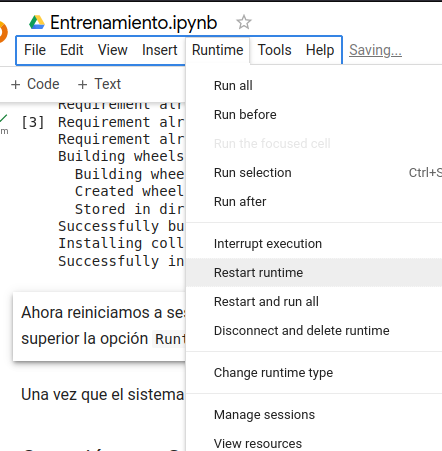

Una vez que el sistema reinicia, procedemos directo al siguiente paso (no hace falta volver a ejecutar las celdas anteriores)

## Conexión con Google Drive

Para poder guardar el modelo de detección que entrenemos (y para continuar el proceso en futuras sesiones, entrenándolo un poco más en cada sesión) vamos a conectar esta instancia de Google Colab a nuestro espacio de almacenamiento en Google Drive.

Al ejecutar la siguiente celda obtendremos un cuadro de diálogo donde se nos pide confirmar que otorgamos acceso a nuestros archivos en Drive. Diremos que si.

In [4]:
# from google.colab import drive
# drive.mount('/content/drive')

Y ahora, todo listo para trabajar.

## Entrenando un modelo de detección de basurales

Entrenar una red neuronal capaz de identificar basura -o cualquier otra categoría de objetos de interés- requiere de un esfuerzo considerable dedicado a generar datos pre-clasificados para utilizar como referencia. En nuestro caso, una buena cantidad de imágenes donde la presencia de basura ya ha sido delimitada (o etiquetada, en la jerga del _machine learning_) "a mano", por labor humana. A esto llamamos un _dataset_ de entrenamiento.

Disponiendo de un conjunto ya etiquetado de imágenes, el siguiente paso es usarlo como input de una red neuronal de segmentación de imagen. Esta red neuronal no es otra cosa que una serie de operaciones matemáticas, determinadas por prueba y error mediante enorme potencia de procesamiento, que "aprenden" a detectar los patrones de formas, colores y posiciones en una imagen que con mayor frecuencia coinciden con la presencia del objeto de interés, demarcado manualmente en las imágenes de entrenamiento.

Este proceso produce un "modelo", un archivo que contiene instrucciones -un algoritmo- para realizar las operaciones sobre el input que han resultado en mejor capacidad de detección. Este modelo luego puede ser alimentado con imágenes nuevas, que no hemos visto antes, para obtener "predicciones": esto es, áreas en las imagenes donde se determina que existe una alta posibilidad de basura.

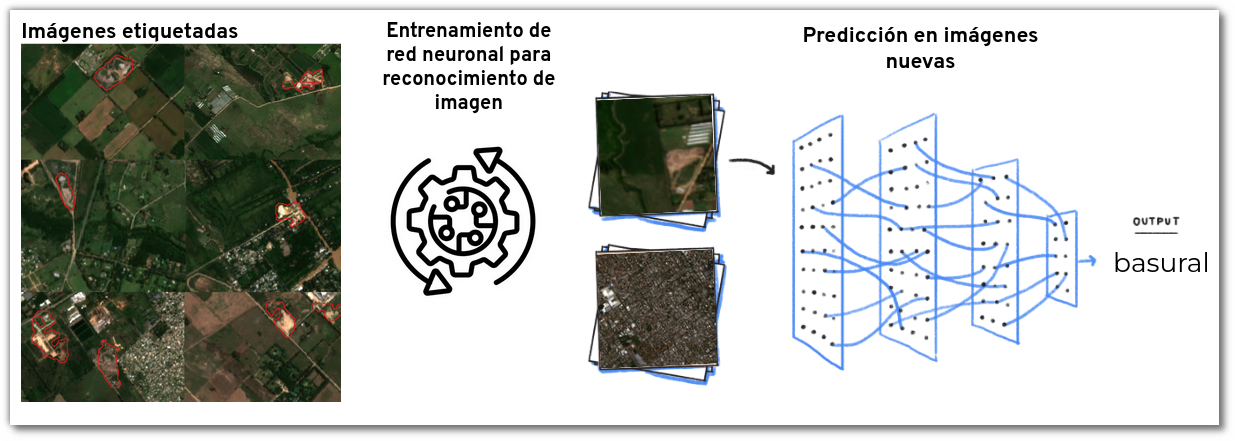

### Librerías

Cargamos todas las librerías de funciones que vamos a necesitar para los siguientes pasos:

In [1]:
!pip install rastervision --user

: 

In [4]:
import os
import subprocess
import rastervision
import rasterio

# os.environ['GDAL_DATA'] = check_output('pip show rasterio | grep Location | awk \'{print $NF"/rasterio/gdal_data/"}\'', shell=True).decode().strip()
# os.environ['AWS_NO_SIGN_REQUEST'] = 'YES'


# Find the location of the 'rasterio' package using pip
try:
    result = subprocess.check_output('pip show rasterio', shell=True).decode('utf-8')

    # Extract the location of the 'rasterio' package
    for line in result.splitlines():
        if line.startswith('Location:'):
            rasterio_location = line.split(':')[-1].strip()
            break
    
    # Set GDAL_DATA environment variable
    gdal_data_path = os.path.join(rasterio_location, 'rasterio', 'gdal_data')
    os.environ['GDAL_DATA'] = gdal_data_path
    print(f"GDAL_DATA has been set to: {gdal_data_path}")

except subprocess.CalledProcessError as e:
    print("Error finding the location of rasterio:", e)

# Set AWS_NO_SIGN_REQUEST environment variable
os.environ['AWS_NO_SIGN_REQUEST'] = 'YES'
print("AWS_NO_SIGN_REQUEST has been set to: YES")


GDAL_DATA has been set to: \Users\oltie\AppData\Local\Programs\Python\Python312\Lib\site-packages\rasterio\gdal_data
AWS_NO_SIGN_REQUEST has been set to: YES


In [9]:
import gdown
import glob

from rastervision.core.data import RasterioSource, MinMaxTransformer

from rastervision.core.data import (
    ClassConfig, GeoJSONVectorSource, RasterioCRSTransformer,
    RasterizedSource, ClassInferenceTransformer)

from rastervision.core.data import SemanticSegmentationLabelSource

from rastervision.core.data.utils.geojson import get_polygons_from_uris
from shapely.geometry import Polygon

from rastervision.pytorch_learner import (
    SemanticSegmentationRandomWindowGeoDataset, SemanticSegmentationSlidingWindowGeoDataset, SemanticSegmentationVisualizer)

import albumentations as A

import torch
from torch.utils.data import ConcatDataset

from rastervision.pytorch_learner import SemanticSegmentationGeoDataConfig
from rastervision.pytorch_learner import SolverConfig
from rastervision.pytorch_learner import SemanticSegmentationLearnerConfig
from rastervision.pytorch_learner import SemanticSegmentationLearner


c:\Users\oltie\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Matplotlib is building the font cache; this may take a moment.


### Obtención de imagen(es) a analizar

A diferencia de los grandes basurales a cielo abierto, que son visibles en [imágenes satelitales de acceso público](https://apps.sentinel-hub.com/eo-browser/), los micro-basurales ocupan superficies relativamente pequeñas y sólo pueden ser observados en imagen aérea como la que se captura con vuelos de dron. Por su utilidad para múltiples aspectos de la gestión urbana, en ocasiones los municipios obtienen estas imágenes. Con ello ya se dispone del elemento más difícil de conseguir para realizar la detección de basurales. Para practicar aquí, utilizaremos imágenes compartidas en [OpenAerialMap](https://map.openaerialmap.org), un servicio online que permite buscar y descargar imágenes aéreas producidas por drones, de libre acceso.

Elegimos esta [imagen aérea](https://map.openaerialmap.org/#/-60.5915629863739,-33.89530130510735,16/square/210321023130122113/5fe3676dff40f100073ca17f?_k=v3z3p7), que captura territorio urbano y periurbano. Fue producida y publicada con licencia abierta por el [Municipio de Pergamino en la Provincia de Buenos Aires, Argentina](http://www.pergamino.gob.ar/ide/).

Luce así:

*Imágen aérea producida por la [Municipalidad de Pergamino](https://www.pergamino.gob.ar/ide/) publicada bajo licencia abierta [CC BY-SA 4.0](https://creativecommons.org/licenses/by-sa/4.0/deed.es).*

La imagen tiene una resolución de 3 cm por pixel -¡muy alta!- y esto permite identificar, por inspección visual, la presencia de basura.

Esto se verifica al hacer zoom:

A descargar entonces.

Copiamos el link al que apunta el ícono de descarga, y lo usamos para obtener el archivo y guardarlo en el sistema donde corre esta instancia de Google Colab:

In [10]:
year = 2021

In [11]:
import urllib.request

# Define the URL and destination file path
image_url = "https://oin-hotosm.s3.amazonaws.com/5fe36263ee72110005bc0b60/0/5fe36263ee72110005bc0b61.tif"
image_file_dest = f"./data/img/{year}.tif"

# # Download the file
# urllib.request.urlretrieve(image_url, image_file_dest)

# print(f"Downloaded {image_url} to {image_file_dest}")


## Generación de "anotaciones"

El siguiente ingrediente que necesitamos es un conjunto de ejemplos del objeto de interés, nuestros basurales, presentes en la imagen. En la jerga del _machine learning_ a estos ejemplos de lo que queremos identificar se les llama "etiquetas" (_labels_) o también "anotaciones" (_annotations_); éste último término se usa en particular cuando trabajamos con imágenes. Si tenemos suerte podemos descargar un conjunto de anotaciones ya generado por otras personas, y poner manos a la obra con nuestra red neuronal. Pero en general, deberemos crear nuestras propias anotaciones mirando la escena y marcando polígonos con software como [QGIS](qgis.org/).

Para practicar, disponemos de unas anotaciones ya creadas que señalan los basurales encontrados en la imagen aérea que obtuvimos en el paso previo.

Proyectadas sobre la imagen aérea, las anotaciones lucen así:

Las descargamos, y las guardamos junto al resto de los ingredientes, en nuestra carpeta de Google Drive -dentro de IA/basurales/anotaciones:

In [12]:
import gdown

annotations_url = "https://drive.google.com/file/d/1eaWBDiu4Lqfu23dyURIvWJWUjCwDJ5Gd/view?usp=drive_link"
annotations_file_dest = f"./data/labels/{year}.gpkg"
\
# gdown.download(annotations_url, annotations_file_dest, fuzzy=True)

### Área de interés (o _AoI_ , "_Area of Interest_")

Es recomendable definir también un área de interés. Esto es simplemente uno o varios polígonos que demarcan la porción de la imagen que nos importa procesar al entrenar al algoritmo.

Esto es útil cuando disponemos de imágenes de considerable extensión donde los objetos de interés sólo aparecen en un área acotada, ya que evitamos perder mucho tiempo procesando superficie donde sabemos que no habrá -o no nos interesan- resultados.

En la práctica, definir cómo área de interés un buffer (área circundante) de 1000 a 1500 metros en torno a cada basural ha funcionado bien, pero podría tambien dibujarse un área de interés a mano alzado, englobando los basurales y sus alrededores cercanos.

Por supuesto tenemos una _AoI_ lista para usar, que luce así junto a las anotaciones:

A descargar:

In [13]:
AoI_url = "https://drive.google.com/file/d/1xjm-FE66SWzf5UaK-LzLU77h1DpNi3sr/view?usp=drive_link"
AoI_file_dest = "./data/aoi/La_matanza.gpkg"

# gdown.download(AoI_url, AoI_file_dest, fuzzy=True)

Hacer que todos tengan las mismas coordenadas

Antes de continuar, una **aclaración importante**: para que sean compatibles con las funciones de `rastervision`, todos los archivos con polígonos georreferenciados -anotaciones y área de interés- deben tener proyección geográfica WGS 84. también conocida como EPSG:4326.

In [12]:
import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling
import os

def reproject_raster_inplace(raster_path, target_crs):
    """
    Reprojects the raster to a specified CRS and overwrites the original file.
    
    Args:
        raster_path (str): Path to the raster file to be reprojected.
        target_crs (str): Target CRS in EPSG format, e.g., "EPSG:4326".
    
    Returns:
        None
    """
    # Temporary output file to avoid writing to the same file while it is open
    temp_raster_path = raster_path + "_temp.tif"
    
    # Open the input raster file
    with rasterio.open(raster_path) as src:
        # Calculate the transform and new dimensions for the target CRS
        transform, width, height = calculate_default_transform(
            src.crs, target_crs, src.width, src.height, *src.bounds)
        
        # Define the metadata for the reprojected raster
        kwargs = src.meta.copy()
        kwargs.update({
            'crs': target_crs,
            'transform': transform,
            'width': width,
            'height': height
        })
        print(f"Raster old CRS: {src.crs}")
        # Write the reprojected raster to the temporary file
        with rasterio.open(temp_raster_path, 'w', **kwargs) as dst:
            for i in range(1, src.count + 1):
                reproject(
                    source=rasterio.band(src, i),
                    destination=rasterio.band(dst, i),
                    src_transform=src.transform,
                    src_crs=src.crs,
                    dst_transform=transform,
                    dst_crs=target_crs,
                    resampling=Resampling.nearest
                )
            print(f"Raster new CRS: {dst.crs}")
    # Overwrite the original file with the reprojected data
    os.remove(raster_path)  # Remove the original raster
    os.rename(temp_raster_path, raster_path)  # Rename the temporary file

    print(f"Raster reprojected and overwritten at {raster_path}")

# Example usage
raster_path = './data/img/2021.tif'
target_crs = "EPSG:4326"

reproject_raster_inplace(raster_path, target_crs)


Raster old CRS: EPSG:4326
Raster new CRS: EPSG:4326
Raster reprojected and overwritten at ./data/img/2021.tif


In [16]:
import fiona
from fiona.transform import transform_geom

def reproject_annotations(input, output, driver, target_crs="EPSG:4326"):
    """
    Reprojects the geometries in a GeoPackage to a specified target CRS and saves the result.
    
    Args:
        input_gpkg (str): Input GPKG or geojson file path.
        output_gpkg (str): Output GPKG or geojson file path.
        target_crs (str): CRS to which geometries will be transformed. Default is "EPSG:4326".
    
    Returns:
        None
    """
    # Open the input GeoPackage
    with fiona.open(input, 'r', driver=driver) as src:
        # Copy the schema and create a new GPKG with the target CRS
        print("src CRS:", src.crs)
        with fiona.open(output, 'w', crs=target_crs, driver=driver, schema=src.schema) as dst:
            for feature in src:
                # Transform the geometry to the target CRS
                geom = transform_geom(src.crs, target_crs, feature['geometry'])
                feature['geometry'] = geom
                dst.write(feature)
            print("dst CRS:", dst.crs)
    print(f"Reprojected label saved to {output}")
    os.remove(input)
# Example usage
input_gpkg = './data/2021.gpkg'
output_gpkg = annotations_file_dest
target_crs = "EPSG:4326"

reproject_annotations(input_gpkg, output_gpkg,'GPKG', target_crs)
reproject_annotations('./data/La_matanza.gpkg',AoI_file_dest,'GPKG', target_crs)


DriverError: Failed to open dataset (flags=68): ./data/2021.gpkg

## Preprocesamiento: extracción de recortes para entrenamiento y test

Ahora hay que enfrentar el problema de como analizar una imagen quizás inmensa (de varios gigas de tamaño, en ocasiones), teniendo en cuenta que la memoria disponible en la GPU es limitada.

La solución es dividir la imagen aérea en una colección de recortes cuadrados (o "ventanas"), de mucho menor tamaño, para ser analizados uno a uno y permiter que el algoritmo aprenda a reconocer patrones que coinciden coon la presencia de basura de acuerdo a las anotaciones. Esta es una de las tareas donde nos ayudan las funciones de la librería [rastervision](https://rastervision.io/).

El tamaño de las ventanas es importante, por que afectan la performance de entrenamiento del modelo, pero no hay una receta exacta para definirlo. En general, cuanta mayor resolución presentan las imágenes a analizar, más nos vamos a beneficiar de usar ventanas grandes.

* Para imágenes satelitales de acceso público con resolucioń moderada, como las del [proyecto Sentinel](https://apps.sentinel-hub.com/eo-browser/) (10 metros por pixel), podemos usar recortes de 128 x 128 píxeles.
* Para imágenes de satélites comerciales, o fotos aéres tomadas a gran altura, podemos usar 256 x 256.
* Y para imágenes de altísima resolución, como estas de 3 cm/pixel, probar con 480 x 480 píxeles como haremos a continuación.

Como es típico en aplicaciones de machine learning, vamos a separar nuestras datos en dos conjuntos, o "datasets": Un dataset de imágenes **de entrenamiento** que se van a usar para que el algoritmo aprenda, y otro dataset **de validación**  que se va a utilizar para medir su performance.

Como paso adicional de preprocesamiento, es una práctica común realizar una serie de distorsiones sobre los recortes de la imagen antes de pasarlos al algoritmo durante la fase de entrenamiento: al azar cambiarles el brillo, la saturación, borrar algunos de los píxeles, etc. A estos ajustes se les llama __"augmentations"__.

Aunque parezca destructivo, es comprobable que esto mejora la performance del algoritmo. Lo hace más robusto a la hora de aplicarlo para detectar objetos en otras imágenes, que no se han usado para su entrenamiento, y que siempre presentarán diferencias -por menores que sean- en saturación, brillo, pixeles faltantes, etc.

Con el siguiente código definimos importantes parámetros: la clase de objeto a detectar, el tamaño de los recortes de imagen a procesar, y las _augmentations_ con las que torturaremos a esos recortes:

In [17]:
# Aquí definimos las clases (tipos de objeto) presentes en nuestras anotaciones
# en este caso tenemos sólo una, que indicamos como "basural" .
# hay un clase adicional, implícita, que es "background" -el fondo, todo lo que
# no corresponde a objetos de intéres

class_config = ClassConfig(
    names=['background', 'asentamiento informal'],
    colors=['lightgray', 'darkred'],
    null_class='background')


# el tamaño en píxeles de los recortes cuadrados
window_size = 480

# Aquí definimos algunas transformaciones a realizar a los recorte del dataset
# de entrenamiento: cambiar al azar la saturación, el brillo, rotarlos, ocultar
# algunos pixeles. Todo esto sirve para entrenar un algoritmo de detección
# más robusto a diferencias que puedan tener las futuras imágenes a las que
# se aplique
data_augmentation_transform = A.Compose([
    A.Flip(),
    A.ShiftScaleRotate(),
    A.OneOf([
        A.HueSaturationValue(hue_shift_limit=10),
        A.RandomBrightnessContrast(),
        A.RandomGamma(),
    ]),
    A.CoarseDropout(max_height=int(window_size/6), max_width=int(window_size/6), max_holes=4)
])


### Generación de datasets de entrenamiento y de validación

El dataset de validación se utiliza para medir la performance de detección: Tras cada iteración en la cual el algoritmo ha procesado ejemplos de basurales para "aprender" los rasgos visuales que se asociana su presencia, evaluamos la performance lograda haciendo que recorra cada punto del área de trabajo, registrando si identifica cada instancia conocida.

Para esto sólo necesitamos dividir el área en una grilla de ventanas contiguas del tamaño que decidimos antes. Este mosaico luciría así:

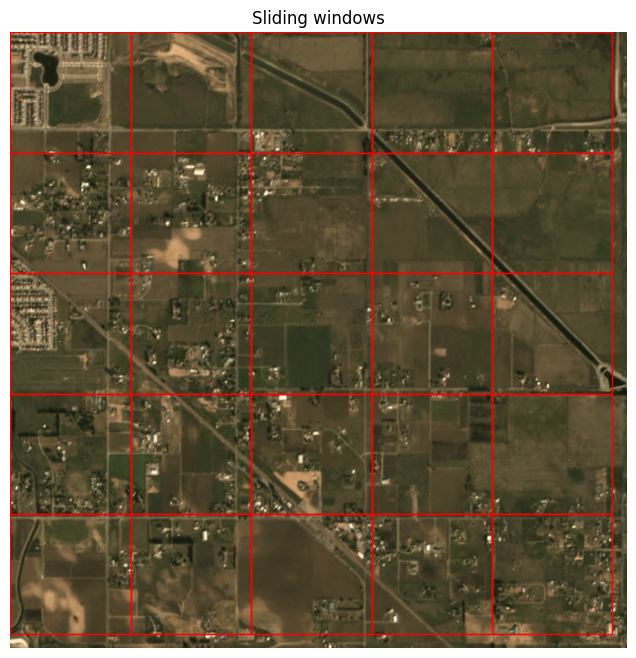

Y podemos definirlo con el siguiente código:



In [18]:
val_ds = SemanticSegmentationSlidingWindowGeoDataset.from_uris(
    class_config=class_config,
    aoi_uri=AoI_file_dest,
    # aoi_uri=annotations_file_dest,
    image_uri=image_file_dest,
    label_vector_uri=annotations_file_dest,
    label_vector_default_class_id=class_config.get_class_id('asentamiento informal'),
    image_raster_source_kw=dict(allow_streaming=True, raster_transformers=[MinMaxTransformer()]),
    size=window_size,
    stride=window_size,
    transform=A.Resize(window_size, window_size))

Echemos un vistazo a uno de estos recortes sobre nuestra imagen, para darnos una mejor idea de su composición:

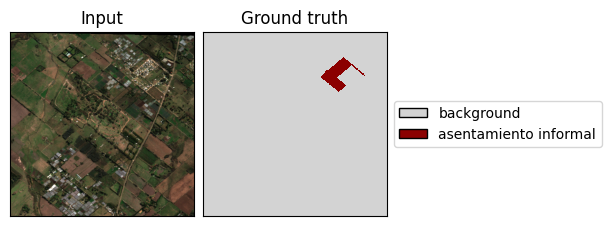

In [19]:
vis = SemanticSegmentationVisualizer(
    class_names=class_config.names, class_colors=class_config.colors)

x, y = val_ds[1]

vis.plot_batch(x.unsqueeze(0), y.unsqueeze(0), show=True)

Para el dataset de entrenamiento, el que algoritmo va a procesar, comparando con las anotaciones para descubrir que patrones corresponden a la presencia de basurales, queremos un muestreo al azar en lugar de un mosaico de ventanas contiguas.

Aunque no sea muy intuitivo en principio, el muestreo al azar con ventanas que se solapan produce mejores resultados que entrenar al algoritmo con imágenes en una grilla regular en las que ningun pixel se repite entre recortes.

Un muestreo al azar luciría así:

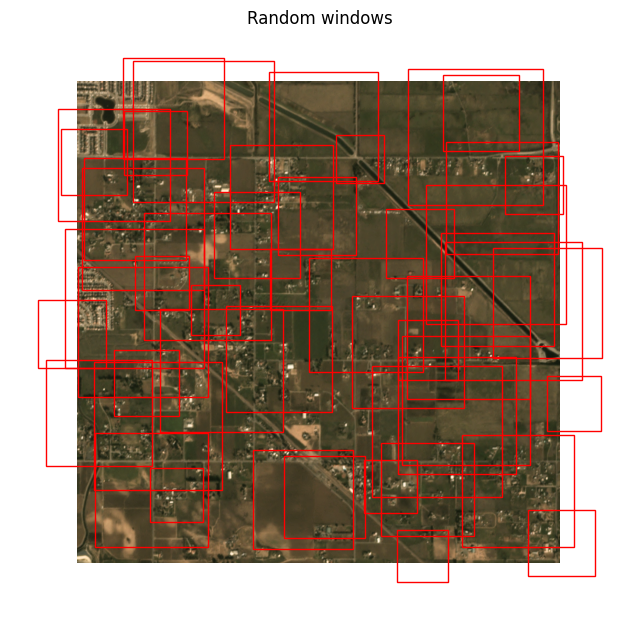

Otra ventaja del muestreo al azar es que podemos producir infinidads de recortes, todos levemente distintos, y así producir un dataset de entrenamiento con tantos ejemplos como querramos.

Para hacer _machine learning_ esto es una gran noticia, ya que siempre vienen bien más datos. ¡Pero! Nos encontraremos con las limitaciones de nuestro hardware. Con imagen de altísima resolucion, y en consecuencia ventanas bastante grandes como las que estamos usando aquí, cada ciclo de entrenamiento podría tomar horas, e incluso fallar por falta de memoria antes de completar.

Por eso, digamos que una buena práctica es elegir un muestreo abundante, para tener muchos mas ejemplos de entrenamiento que de validación. Como tantas otras cosas en este mundillo de la IA, el número se elige según el caso, probando y comparando alternativas.

Pero digamos que para imágenes de resolución más modesta, y/o dispinibilidad de hardware más potente que el de Google Colab, pediríamos una cantidad de muestras 5 veces mayor a la cantidad de recortes en el dataset de validación.

Pero habiendo realizado pruebas con esta imagen de input y una instancia de Google Colab circa 2023, nos tendremos que conformar con un muestreo más pequeño. Digamos la misma cantidad que la de recortes en el dataset de validación.

Y así es como lo definimos para realizarse sobre nuestra imagen:

In [20]:
# Aquí definimos cuantos recortes sobre la imagen tomaremos al azar
# idealmente, varias veces la cantidad de recortes en el dataset de validación
# (algo así como sample_size = len(val_ds) * 5
# pero como estos datos son "pesados" vamos a limitarnos a tomar una muestra de la misma cantidad
sample_size = len(val_ds)*5

train_ds = SemanticSegmentationRandomWindowGeoDataset.from_uris(
    class_config=class_config,
    # aoi_uri=AoI_file_dest,
    image_uri=image_file_dest,
    label_vector_uri=annotations_file_dest,
    label_vector_default_class_id=class_config.get_class_id('asentamiento informal'),
    image_raster_source_kw=dict(allow_streaming=True, raster_transformers=[MinMaxTransformer()]),
    # window sizes will randomly vary from 100x100 to 300x300
    #size_lims=(100, 300),
    # fixed window size
    size_lims=(window_size, window_size+1),
    # resize chips before returning
    out_size=window_size,
    # allow windows to overflow the extent by 100 pixels
    padding=100,
    max_windows=sample_size, # pero como estos datos son "pesados" vamos a limitarnos a tomar una muestra de la misma cantidad
    transform=data_augmentation_transform
)

In [ ]:
# train_ds_long = LongTargetDataset(train_ds)

# # Now, val_ds_long will return LongTensor targets
# for data in train_ds_long:
#     x, y = data
#     print(f"Input tensor type: {x.dtype}, Target tensor type: {y.dtype}")

Elijamos unos cuantos de estos recortes al azar, a ver como quedan: (para notar que realmente son al azar, ejecuten el código varias veces para obtener resultados distintos)

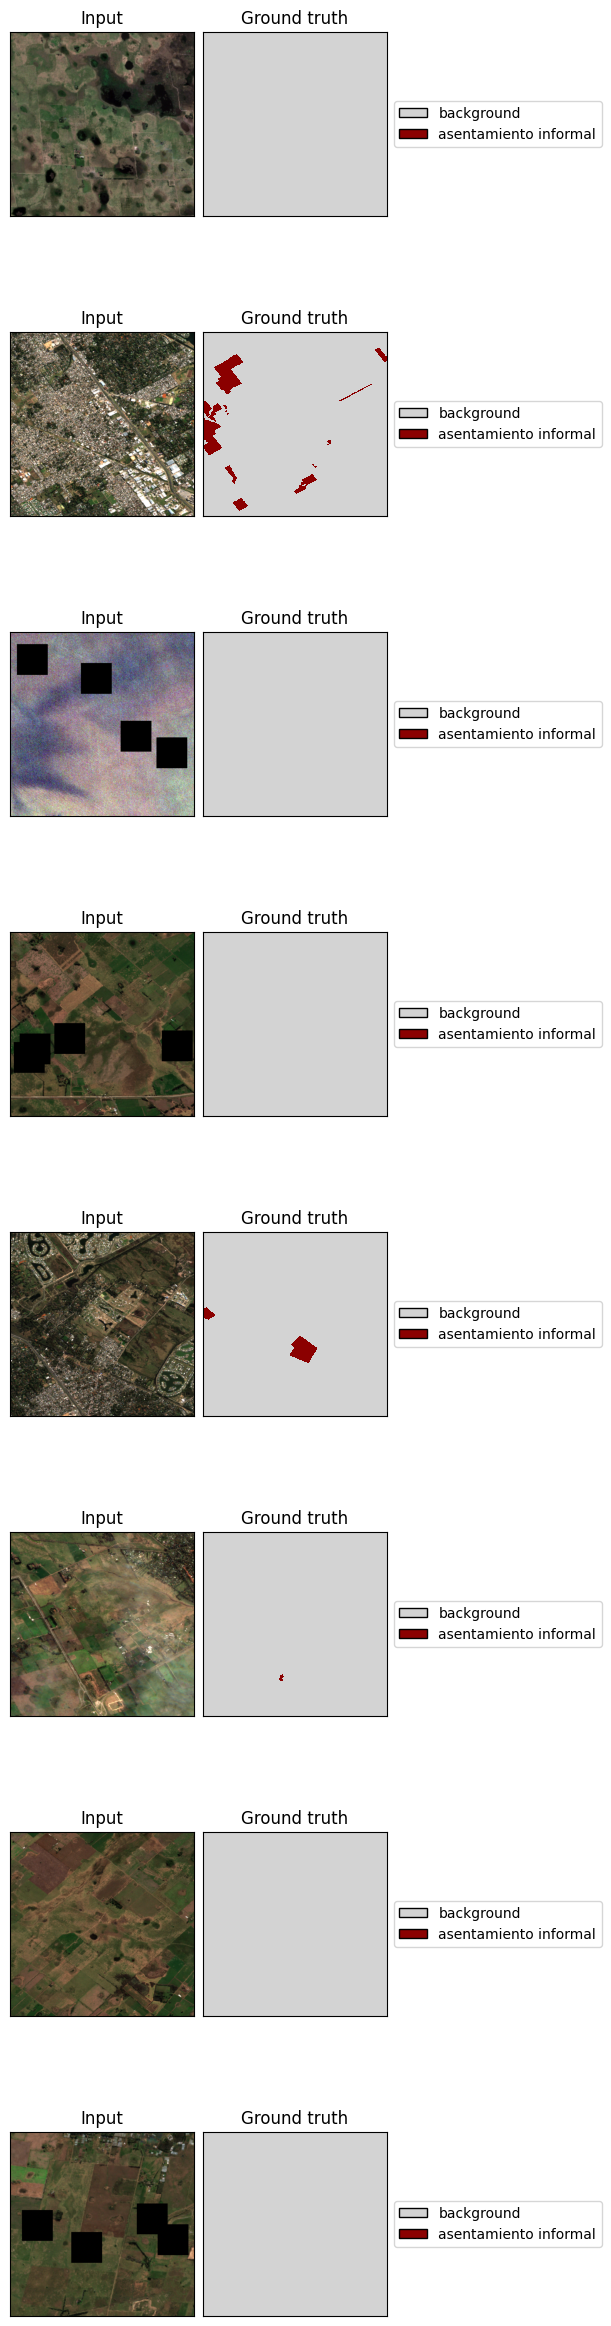

In [21]:
x, y = vis.get_batch(train_ds, 8)

vis.plot_batch(x, y, show=True)

Y con eso, todo listo para iniciar el proceso de entrenamiento.

## Entrenando un modelo de clasificación de imagen

Explicar la lógica del funcionamiento de las redes neuronales excede las miras de este tutorial, así que iremos directo a su aplicación. Pero quien quiera entender como opera esta tecnología, puede recurrir a los primeros 5 capítulos del ya clásico "[Deep Learning with Python](https://www.manning.com/books/deep-learning-with-python-second-edition)", de François Chollet.


Ahora, volviendo a lo nuestro...

En lugar de partir de cero, tomaremos como base un modelo de uso general llamado _RESNET18_, una red neuronal de uso general que puede re-entrenarse para ser especializada en cualquier clase específica de objetos de interés.

Definimos el modelo base con el que vamos a trabajar:

	
Fully-Convolutional Network model with a ResNet-50 backbone from the Fully Convolutional Networks for Semantic Segmentation paper. 
https://arxiv.org/abs/1411.4038

In [22]:
import torch

model = torch.hub.load(
    'AdeelH/pytorch-fpn:0.3',
    'make_fpn_resnet',
    name='resnet18',
    fpn_type='panoptic',
    num_classes=len(class_config),
    fpn_channels=128,
    in_channels=3,
    out_size=(window_size, window_size),
    pretrained=True)


Using cache found in C:\Users\oltie/.cache\torch\hub\AdeelH_pytorch-fpn_0.3


Ahora configuramos las opciones para el entrenamiento, entre ellas:

* Cuántas iteraciones (la cantidad de veces que se volverán a recorrer los datos, buscando mejorar la predicción en base a lo aprendido en el ciclo anterior). Cuantas más, mejor para buscar mejores resultados -pero una cantidad grande de iteraciones puede tomar muchas, muchas horas.

* Cuántas imágenes analizar al mismo tiempo, en tandas (cuantas más mejor, pero el límite lo fija la cantidad de memoria GPU RAM)

* En que archivo guardar el modelo con sus parámetros actualizados, tras cada iteracion

* Cuáles son los datasets de entenamiento y de validación que utilizará para encontrar los mejores resultados. Estos son los que definimos en el paso anterior.



In [23]:
# Donde vamos a guardar el modelo entrenado
model_folder =  "./data/model/"

# cantidad de iteraciones
n_epochs = 2

# cantidad de imagenes a cargar por iteración
# (limitada por la cantidad de memoria GPU y de memoria RAM)
# en los 15Gb RAM de la GPU de Google Colab entran tandas
# de hasta 60 imagenes de 480x480px

batch_images = 100
# Cuál es la configuración de clases a identidicar
data_cfg = SemanticSegmentationGeoDataConfig(
    class_config=class_config,
    num_workers=0, # incrementar este valor habilita multiproceso, pero causa problemas en Colab
)

# Cuántas imágenes a cargar en memoria a la vez
solver_cfg = SolverConfig(
    batch_sz=batch_images,
    lr=0.01
)


# combinamos todas las opciones en un objeto "learner",
# que es el que realizará el entrenamiento
learner_cfg = SemanticSegmentationLearnerConfig(data=data_cfg, solver=solver_cfg)

learner = SemanticSegmentationLearner(
    cfg=learner_cfg,
    output_dir=model_folder,
    model=model,
    train_ds=train_ds,
    valid_ds=val_ds,
    training=True,
)

2024-09-19 00:52:49:rastervision.pytorch_learner.learner: INFO - Building dataloaders


Y con todo definido, finalmente... ¡a entrenar!:

In [24]:
learner.train(epochs=n_epochs)

2024-09-19 00:52:52:rastervision.pytorch_learner.learner: INFO - train_ds: 2730 items
2024-09-19 00:52:52:rastervision.pytorch_learner.learner: INFO - valid_ds: 546 items
2024-09-19 00:52:52:rastervision.pytorch_learner.learner: INFO - Plotting sample training batch.
2024-09-19 00:53:38:rastervision.pytorch_learner.learner: INFO - Plotting sample validation batch.
2024-09-19 00:54:20:rastervision.pytorch_learner.learner: INFO - epoch: 0
Validating: 100%|██████████| 6/6 [02:01<00:00, 20.29s/it]
2024-09-19 01:33:43:rastervision.pytorch_learner.learner: INFO - metrics:
{'epoch': 0,
 'train_loss': 0.12425434589385986,
 'train_time': '0:37:20.569485',
 'val_loss': 0.06002460792660713,
 'avg_precision': 0.9692057371139526,
 'avg_recall': 0.98448246717453,
 'avg_f1': 0.9767844080924988,
 'background_precision': 0.98448246717453,
 'background_recall': 1.0,
 'background_f1': 0.9921805262565613,
 'asentamiento informal_precision': 0.0,
 'asentamiento informal_recall': 0.0,
 'asentamiento informa

Cuando hayamos logrado obtener un modelo con buena performance, podemos guardarlo en formato .zip, que guarda, y permite transpotar a cualquer otro sistema, todos los archivos necesarios para usar nuestro modelo en el futuro; por ejemplo, para aplicarlo a imágenes nuevas donde indique los sitios donde detecta basurales en base a lo aprendido con nuestros ejemplos.

La función `save_model_bundle()` guarda un archivo con nombre "model-bundle.zip" en la carpeta que definimos antes, al momento de configurar el entrenamiento:

In [25]:
learner.save_model_bundle()

2024-09-19 02:20:06:rastervision.pytorch_learner.learner: WARNING - Model was not configured via ModelConfig, and therefore, will not be reconstructable form the model-bundle. You will need to initialize the model yourself and pass it to from_model_bundle().
2024-09-19 02:20:06:rastervision.pytorch_learner.learner: INFO - Creating bundle.
2024-09-19 02:20:09:rastervision.pytorch_learner.learner: INFO - Exporting to model to ONNX.
2024-09-19 02:20:50:rastervision.pytorch_learner.learner: INFO - Saving bundle to ./data/model/model-bundle.zip.
Zipping: 2it [00:02,  1.22s/it, model.pth]      

Para lograr buenos resultados, es muy probable que necesitemos una buena cantidad de iteraciones del proceso, no sólo dos como hemos ensayado aquí.

Un obstáculo para ello es que la versión gratuita de Google Colab se interrumpe automáticamente tras unas horas de uso. A veces 4, a veces 8 horas (no parece haber un tiempo exacto), pero en todo caso lejos de ser tiempo suficiente para correr nuestro proceso de entrenamiento las muchas, muchas veces que necesita analizar los datos para encontrar un buen modelo de detección. Una vez que se agotó la capacidad gratuita, para poder volver a utilizar los recursos necesitamos pasar a la versión paga del servicio, o esperar al día siguiente cuando se nos vuelve a dar acceso a unas horas de procesamiento.

Google Colab es una gran opción para practicar, por su gratuidad y facilidad para compartir código y datos. ¡Pero! A la hora de la verdad, al trabajar en un proyecto propio con datos de muy alta resolución, como los que hemos tomado de ejemplo aquí, valdría la pena...

- Intentar con un proveedor alternativo que ofrezca más horas continuas de uso gratuito, como [Saturn Cloud](https://saturncloud.io)

- Contar con un equipo propio donde correr el código, que podamos usar todo el tiempo que querramos

- Comprar tiempo de procesamiento extra -como un pack de 100 horas de procesamiento, por decir algo- a un proveedor como el propio Google Colab o el ya mencionado Saturn Cloud, que aceptarán nuestra tarjeta de crédito con alegría

Y por supuesto, también usar imágenes de menor resolución, que se pueden procesar con mucha mayor velocidad. Por ejemplo la imágenes descargadas de Google Earth/Google Maps, a nivel de zoom 17, cubren un área similar a la de nuestro ejemplo con muchísimos menos píxeles de resolución pero aún así son adecuadas para detectar los basurales de tamaño importante.

Por último,  si tenemos paciencia -y si aceptamos el uso de imágenes con resolución más modesta-, podemos continuar el entrenamiento en distintas sesiones de Colab, corriendo exactamente el mismo código. Esto es posible gracias a que `rastervision` detecta que en la carpeta de destino para el modelo ya existe una versión previa, y la toma como punto de partida para seguir mejorando las métricas de detección.

Para dar una idea de la capacidad de procesamiento -o paciencia- requerida para entrenar un modelo ambicioso como el que tenemos entre manos, la siguiente captura de pantalla muestra que para lograr `precision` y `recall` arriba del 90% se han necesitado 1361 iteraciones - más de 100 horas de procesamiento en una GPU similar a la que ofrece Google Colab:

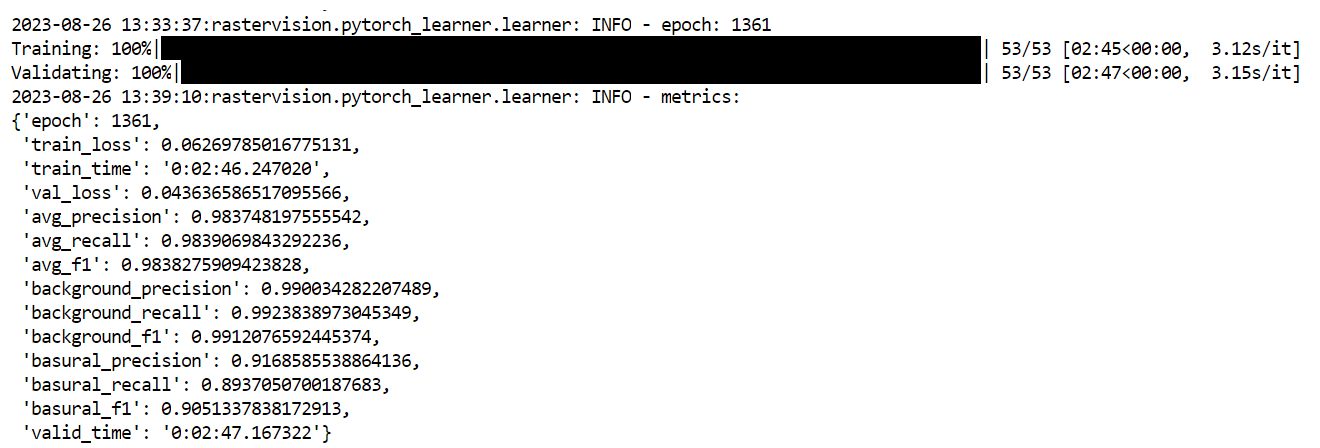

Con esto terminamos el tutorial de entrenamiento, pero antes repasemos dos buenas noticias:

1. Por más que los modelos de detección tengan una performance muy baja en sus primeras iteraciones, ya vemos que con suficiente tiempo se logran buenos resultados

2. Y para los fines de este ejercicio no necesitamos dedicar todas esas horas, porque el modelo ya entrenado hasta lograr buena performance -cuyas métricas acabamos de mostrar- se encuentra a disposición del público.

**Vamos a usar ese modelo ya entrenado para mostrar qué tan bien aprendió a detectar los basurales conocidos, y qué tan bien los detecta en escenarios nuevos, en el siguiente tutorial:**

###["Detección"](https://colab.research.google.com/drive/1jgyNksHi-53cx98P9Bwk9z4pyygeV41c?usp=sharing)

